In [1]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

DATA_PATH = "./data/processed_dataset.csv"

In [2]:
device = torch.device('cpu')

# Read data

In [3]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,pet_size,pet_type
product_id,,,
5040,0,0,0
4567,1,0,1
4237,1,0,2
4364,2,1,3
4184,3,1,3


In [4]:
y_data = datasheet.iloc[:, 0]
X_data_1 = datasheet.iloc[:, 1].to_numpy().astype(np.float32)
X_data_2 = datasheet.iloc[:, 2].to_numpy().astype(np.float32)

# Train, Test(Validation) Split

In [5]:
onehot_encoder = OneHotEncoder()

y_data = y_data.to_numpy().astype(np.float32)
y_data = onehot_encoder.fit_transform(y_data.reshape(-1, 1)).astype(np.float32).toarray()

print(f"""X_data 1 shape: {X_data_1.shape}
X_data 2 shape: {X_data_2.shape}
y_data shape: {y_data.shape}""")

X_data 1 shape: (879,)
X_data 2 shape: (879,)
y_data shape: (879, 6)


# Datasets & DataLoader

In [6]:
BATCH_SIZE = 32

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X_data_1, X_data_2, y_data):
        self.X_data_1 = X_data_1
        self.X_data_2 = X_data_2
        self.y_data = y_data

    def __getitem__(self, index):
        X_1 = self.X_data_1[index]
        X_2 = self.X_data_2[index]
        y = self.y_data[index]
        return X_1, X_2, y

    def __len__(self):
        return len(self.X_data_1)

In [8]:
train_dataset = CustomDataset(X_data_1, X_data_2, y_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(X_data_1, X_data_2, y_data)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [20]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim


        self.input_linear_1 = nn.Linear(self.input_dim, 32)
        self.input_linear_1_1 = nn.Linear(32, 64)
        self.input_linear_1_2 = nn.Linear(64, 128)
        self.input_linear_1_3 = nn.Linear(128, 256)
        self.input_linear_1_4 = nn.Linear(256, 512)
        # self.gru_1 = nn.GRU(512, 512, batch_first=True)
        
        self.input_linear_2 = nn.Linear(self.input_dim, 32)
        self.input_linear_2_1 = nn.Linear(32, 64)
        self.input_linear_2_2 = nn.Linear(64, 128)
        self.input_linear_2_3 = nn.Linear(128, 256)
        self.input_linear_2_4 = nn.Linear(256, 512)
        # self.gru_2 = nn.GRU(512, 512, batch_first=True)

        self.output_hidden_1 = nn.Linear(1024, 256)
        self.output_hidden_2 = nn.Linear(256, 32)
        self.output_linear = nn.Linear(32, self.output_dim)

    def forward(self, x1, x2):
        x1 = self.input_linear_1(x1)
        x1 = self.input_linear_1_1(x1)
        x1 = self.input_linear_1_2(x1)
        x1 = self.input_linear_1_3(x1)
        x1 = self.input_linear_1_4(x1)
        # x1, _ = self.gru_1(x1)
    
        x2 = self.input_linear_2(x2)
        x2 = self.input_linear_2_1(x2)
        x2 = self.input_linear_2_2(x2)
        x2 = self.input_linear_2_3(x2)
        x2 = self.input_linear_2_4(x2)
        # x2, _ = self.gru_2(x2)

        x = torch.cat([x1, x2], dim=1)
        x = F.relu(self.output_hidden_1(x))
        x = F.relu(self.output_hidden_2(x))
        x = self.output_linear(x)

        return x
    
model = Model(1, 6).to(device)
summary(model.to(device='cpu'), [(1,), (1,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              64
            Linear-2                   [-1, 64]           2,112
            Linear-3                  [-1, 128]           8,320
            Linear-4                  [-1, 256]          33,024
            Linear-5                  [-1, 512]         131,584
            Linear-6                   [-1, 32]              64
            Linear-7                   [-1, 64]           2,112
            Linear-8                  [-1, 128]           8,320
            Linear-9                  [-1, 256]          33,024
           Linear-10                  [-1, 512]         131,584
           Linear-11                  [-1, 256]         262,400
           Linear-12                   [-1, 32]           8,224
           Linear-13                    [-1, 6]             198
Total params: 621,030
Trainable params:

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.03)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lambda epoch: 0.95 ** epoch,
    last_epoch=-1,
    verbose=True
)

Adjusting learning rate of group 0 to 3.0000e-02.


# Model Train & Validation

In [22]:
EPOCHS = 100 

In [23]:
train_loss, val_loss = [], []
for epoch in range(EPOCHS):
    model.train()
    
    running_loss = 0.0
    for idx, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Train Epoch {epoch+1}/{EPOCHS}, Train Loss: {running_loss / len(train_dataloader)}"):
        X_data_1, X_data_2, y_data = data
        X_data_1 = X_data_1.to(device).reshape(-1, 1)
        X_data_2 = X_data_2.to(device).reshape(-1, 1)
        y_data = y_data.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_data_1, X_data_2).reshape(-1, 6)

        loss = criterion(y_pred, y_data)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss.append(running_loss / len(train_dataloader))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Test Epoch {epoch+1}/{EPOCHS}, Test Loss: {running_loss / len(test_dataloader)}"):
            X_data_1, X_data_2, y_data = data 
            X_data_1 = X_data_1.to(device).reshape(-1, 1)
            X_data_2 = X_data_2.to(device).reshape(-1, 1)
            y_data = y_data.to(device)

            y_pred = model(X_data_1, X_data_2).reshape(-1, 6)
            loss = criterion(y_pred, y_data)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            _, y_true = torch.max(y_data.data, 1)
            total += y_data.size(0)
            correct += (predicted == y_true).sum().item()

        val_loss.append(running_loss / len(test_dataloader))

Train Epoch 1/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 140.60it/s]


Adjusting learning rate of group 0 to 2.8500e-02.


Train Epoch 2/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 220.44it/s]


Adjusting learning rate of group 0 to 2.7075e-02.


Train Epoch 3/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.57it/s]


Adjusting learning rate of group 0 to 2.5721e-02.


Train Epoch 4/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 222.97it/s]


Adjusting learning rate of group 0 to 2.4435e-02.


Train Epoch 5/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.36it/s]


Adjusting learning rate of group 0 to 2.3213e-02.


Train Epoch 6/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 224.67it/s]


Adjusting learning rate of group 0 to 2.2053e-02.


Train Epoch 7/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 210.42it/s]


Adjusting learning rate of group 0 to 2.0950e-02.


Train Epoch 8/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 220.58it/s]


Adjusting learning rate of group 0 to 1.9903e-02.


Train Epoch 9/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 209.10it/s]


Adjusting learning rate of group 0 to 1.8907e-02.


Train Epoch 10/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 223.26it/s]


Adjusting learning rate of group 0 to 1.7962e-02.


Train Epoch 11/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 224.82it/s]


Adjusting learning rate of group 0 to 1.7064e-02.


Train Epoch 12/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 174.79it/s]


Adjusting learning rate of group 0 to 1.6211e-02.


Train Epoch 13/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.49it/s]


Adjusting learning rate of group 0 to 1.5400e-02.


Train Epoch 14/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.75it/s]


Adjusting learning rate of group 0 to 1.4630e-02.


Train Epoch 15/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 226.29it/s]


Adjusting learning rate of group 0 to 1.3899e-02.


Train Epoch 16/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.83it/s]


Adjusting learning rate of group 0 to 1.3204e-02.


Train Epoch 17/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.44it/s]


Adjusting learning rate of group 0 to 1.2544e-02.


Train Epoch 18/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 180.99it/s]


Adjusting learning rate of group 0 to 1.1916e-02.


Train Epoch 19/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 195.23it/s]


Adjusting learning rate of group 0 to 1.1321e-02.


Train Epoch 20/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 221.91it/s]


Adjusting learning rate of group 0 to 1.0755e-02.


Train Epoch 21/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 223.27it/s]


Adjusting learning rate of group 0 to 1.0217e-02.


Train Epoch 22/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 158.45it/s]


Adjusting learning rate of group 0 to 9.7060e-03.


Train Epoch 23/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 216.75it/s]


Adjusting learning rate of group 0 to 9.2207e-03.


Train Epoch 24/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 219.50it/s]


Adjusting learning rate of group 0 to 8.7597e-03.


Train Epoch 25/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 222.80it/s]


Adjusting learning rate of group 0 to 8.3217e-03.


Train Epoch 26/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 223.17it/s]


Adjusting learning rate of group 0 to 7.9056e-03.


Train Epoch 27/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 219.48it/s]


Adjusting learning rate of group 0 to 7.5103e-03.


Train Epoch 28/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 198.67it/s]


Adjusting learning rate of group 0 to 7.1348e-03.


Train Epoch 29/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 187.75it/s]


Adjusting learning rate of group 0 to 6.7781e-03.


Train Epoch 30/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 209.53it/s]


Adjusting learning rate of group 0 to 6.4392e-03.


Train Epoch 31/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 186.45it/s]


Adjusting learning rate of group 0 to 6.1172e-03.


Train Epoch 32/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 185.70it/s]


Adjusting learning rate of group 0 to 5.8113e-03.


Train Epoch 33/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 195.04it/s]


Adjusting learning rate of group 0 to 5.5208e-03.


Train Epoch 34/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 205.72it/s]


Adjusting learning rate of group 0 to 5.2447e-03.


Train Epoch 35/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 185.32it/s]


Adjusting learning rate of group 0 to 4.9825e-03.


Train Epoch 36/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 47.10it/s] 


Adjusting learning rate of group 0 to 4.7334e-03.


Train Epoch 37/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 160.26it/s]


Adjusting learning rate of group 0 to 4.4967e-03.


Train Epoch 38/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 200.31it/s]


Adjusting learning rate of group 0 to 4.2719e-03.


Train Epoch 39/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 189.92it/s]


Adjusting learning rate of group 0 to 4.0583e-03.


Train Epoch 40/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 224.40it/s]


Adjusting learning rate of group 0 to 3.8554e-03.


Train Epoch 41/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 168.11it/s]


Adjusting learning rate of group 0 to 3.6626e-03.


Train Epoch 42/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 190.29it/s]


Adjusting learning rate of group 0 to 3.4795e-03.


Train Epoch 43/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 187.28it/s]


Adjusting learning rate of group 0 to 3.3055e-03.


Train Epoch 44/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 187.10it/s]


Adjusting learning rate of group 0 to 3.1402e-03.


Train Epoch 45/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 197.19it/s]


Adjusting learning rate of group 0 to 2.9832e-03.


Train Epoch 46/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 213.00it/s]


Adjusting learning rate of group 0 to 2.8340e-03.


Train Epoch 47/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.68it/s]


Adjusting learning rate of group 0 to 2.6923e-03.


Train Epoch 48/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.96it/s]


Adjusting learning rate of group 0 to 2.5577e-03.


Train Epoch 49/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 171.65it/s]


Adjusting learning rate of group 0 to 2.4298e-03.


Train Epoch 50/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 224.79it/s]


Adjusting learning rate of group 0 to 2.3083e-03.


Train Epoch 51/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 231.10it/s]


Adjusting learning rate of group 0 to 2.1929e-03.


Train Epoch 52/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.12it/s]


Adjusting learning rate of group 0 to 2.0833e-03.


Train Epoch 53/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 230.85it/s]


Adjusting learning rate of group 0 to 1.9791e-03.


Train Epoch 54/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 224.88it/s]


Adjusting learning rate of group 0 to 1.8802e-03.


Train Epoch 55/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.06it/s]


Adjusting learning rate of group 0 to 1.7862e-03.


Train Epoch 56/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.97it/s]


Adjusting learning rate of group 0 to 1.6968e-03.


Train Epoch 57/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 226.79it/s]


Adjusting learning rate of group 0 to 1.6120e-03.


Train Epoch 58/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.70it/s]


Adjusting learning rate of group 0 to 1.5314e-03.


Train Epoch 59/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.73it/s]


Adjusting learning rate of group 0 to 1.4548e-03.


Train Epoch 60/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.08it/s]


Adjusting learning rate of group 0 to 1.3821e-03.


Train Epoch 61/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 198.13it/s]


Adjusting learning rate of group 0 to 1.3130e-03.


Train Epoch 62/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 229.85it/s]


Adjusting learning rate of group 0 to 1.2473e-03.


Train Epoch 63/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 226.74it/s]


Adjusting learning rate of group 0 to 1.1850e-03.


Train Epoch 64/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 150.87it/s]


Adjusting learning rate of group 0 to 1.1257e-03.


Train Epoch 65/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 201.10it/s]


Adjusting learning rate of group 0 to 1.0694e-03.


Train Epoch 66/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 215.84it/s]


Adjusting learning rate of group 0 to 1.0160e-03.


Train Epoch 67/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 212.34it/s]


Adjusting learning rate of group 0 to 9.6517e-04.


Train Epoch 68/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 212.32it/s]


Adjusting learning rate of group 0 to 9.1691e-04.


Train Epoch 69/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 229.12it/s]


Adjusting learning rate of group 0 to 8.7106e-04.


Train Epoch 70/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 204.40it/s]


Adjusting learning rate of group 0 to 8.2751e-04.


Train Epoch 71/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 188.94it/s]


Adjusting learning rate of group 0 to 7.8614e-04.


Train Epoch 72/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 184.70it/s]


Adjusting learning rate of group 0 to 7.4683e-04.


Train Epoch 73/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 201.57it/s]


Adjusting learning rate of group 0 to 7.0949e-04.


Train Epoch 74/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 217.77it/s]


Adjusting learning rate of group 0 to 6.7401e-04.


Train Epoch 75/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 142.05it/s]


Adjusting learning rate of group 0 to 6.4031e-04.


Train Epoch 76/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 44.70it/s] 


Adjusting learning rate of group 0 to 6.0830e-04.


Train Epoch 77/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 114.97it/s]


Adjusting learning rate of group 0 to 5.7788e-04.


Train Epoch 78/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 194.40it/s]


Adjusting learning rate of group 0 to 5.4899e-04.


Train Epoch 79/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 192.84it/s]


Adjusting learning rate of group 0 to 5.2154e-04.


Train Epoch 80/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 223.89it/s]


Adjusting learning rate of group 0 to 4.9546e-04.


Train Epoch 81/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 150.28it/s]


Adjusting learning rate of group 0 to 4.7069e-04.


Train Epoch 82/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 187.62it/s]


Adjusting learning rate of group 0 to 4.4715e-04.


Train Epoch 83/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 205.44it/s]


Adjusting learning rate of group 0 to 4.2480e-04.


Train Epoch 84/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 220.61it/s]


Adjusting learning rate of group 0 to 4.0356e-04.


Train Epoch 85/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 206.38it/s]


Adjusting learning rate of group 0 to 3.8338e-04.


Train Epoch 86/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 219.57it/s]


Adjusting learning rate of group 0 to 3.6421e-04.


Train Epoch 87/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.86it/s]


Adjusting learning rate of group 0 to 3.4600e-04.


Train Epoch 88/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 217.12it/s]


Adjusting learning rate of group 0 to 3.2870e-04.


Train Epoch 89/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 163.65it/s]


Adjusting learning rate of group 0 to 3.1226e-04.


Train Epoch 90/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 222.36it/s]


Adjusting learning rate of group 0 to 2.9665e-04.


Train Epoch 91/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.60it/s]


Adjusting learning rate of group 0 to 2.8182e-04.


Train Epoch 92/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.42it/s]


Adjusting learning rate of group 0 to 2.6773e-04.


Train Epoch 93/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.75it/s]


Adjusting learning rate of group 0 to 2.5434e-04.


Train Epoch 94/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 209.31it/s]


Adjusting learning rate of group 0 to 2.4162e-04.


Train Epoch 95/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 223.68it/s]


Adjusting learning rate of group 0 to 2.2954e-04.


Train Epoch 96/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 226.47it/s]


Adjusting learning rate of group 0 to 2.1807e-04.


Train Epoch 97/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.62it/s]


Adjusting learning rate of group 0 to 2.0716e-04.


Train Epoch 98/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 227.93it/s]


Adjusting learning rate of group 0 to 1.9680e-04.


Train Epoch 99/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 228.90it/s]


Adjusting learning rate of group 0 to 1.8696e-04.


Train Epoch 100/100, Train Loss: 0.0: 100%|██████████| 28/28 [00:00<00:00, 225.88it/s]


Adjusting learning rate of group 0 to 1.7762e-04.


Test Epoch 100/100, Test Loss: 1.6865833359105247: 100%|██████████| 28/28 [00:00<00:00, 1208.05it/s]


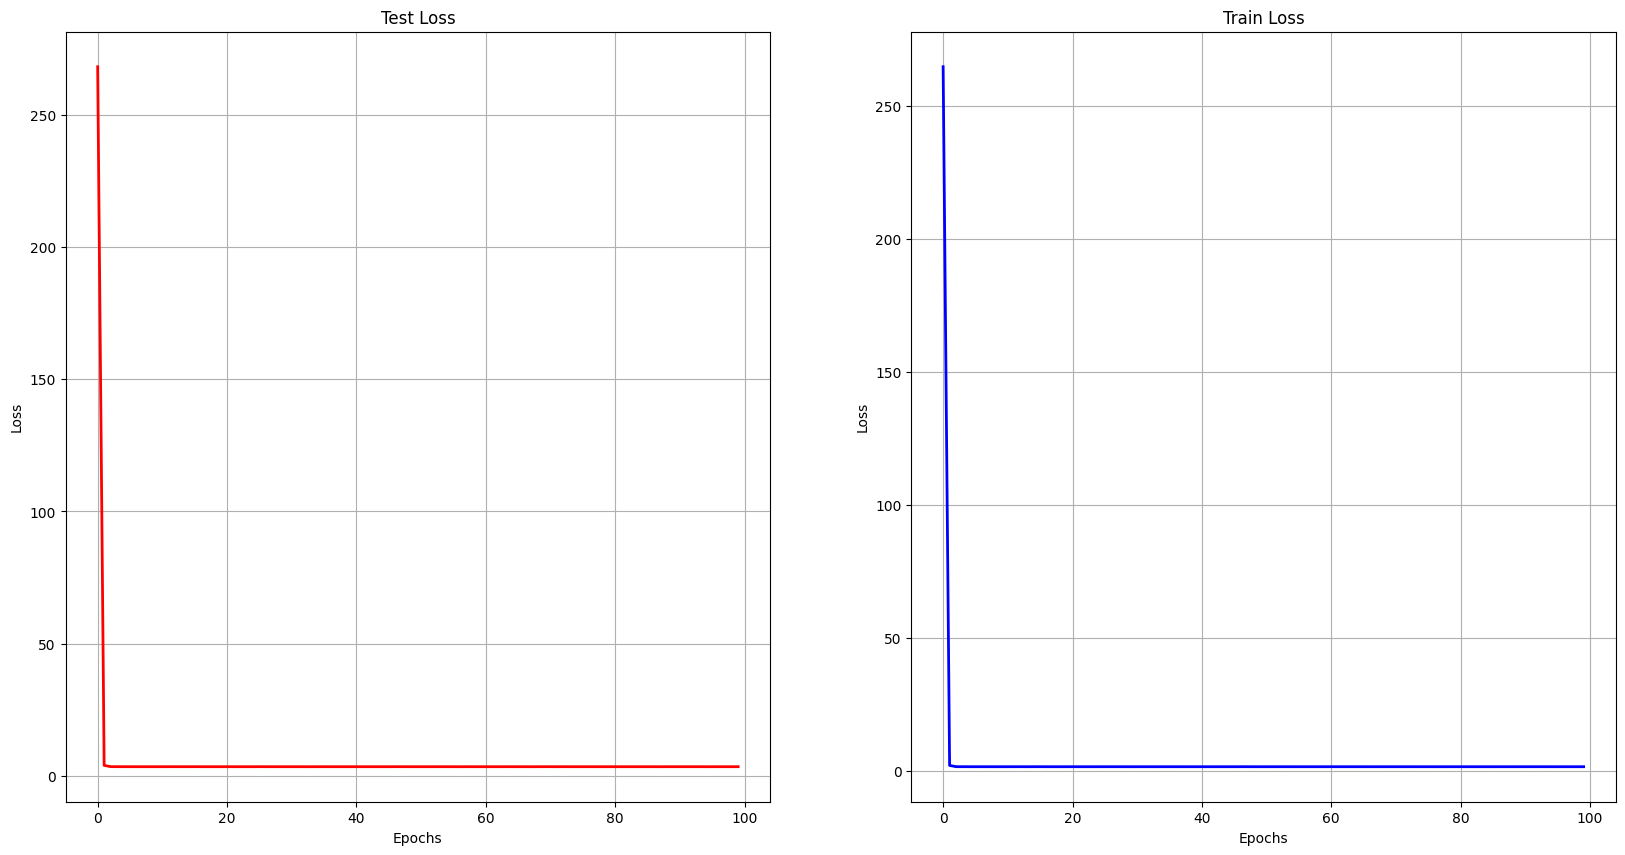

In [24]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Test Loss")
plt.plot(val_loss, label='test loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Train Loss")
plt.plot(train_loss, label='train loss', color='blue', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

# Evaluation

In [25]:
model.eval()

Model(
  (input_linear_1): Linear(in_features=1, out_features=32, bias=True)
  (input_linear_1_1): Linear(in_features=32, out_features=64, bias=True)
  (input_linear_1_2): Linear(in_features=64, out_features=128, bias=True)
  (input_linear_1_3): Linear(in_features=128, out_features=256, bias=True)
  (input_linear_1_4): Linear(in_features=256, out_features=512, bias=True)
  (input_linear_2): Linear(in_features=1, out_features=32, bias=True)
  (input_linear_2_1): Linear(in_features=32, out_features=64, bias=True)
  (input_linear_2_2): Linear(in_features=64, out_features=128, bias=True)
  (input_linear_2_3): Linear(in_features=128, out_features=256, bias=True)
  (input_linear_2_4): Linear(in_features=256, out_features=512, bias=True)
  (output_hidden_1): Linear(in_features=1024, out_features=256, bias=True)
  (output_hidden_2): Linear(in_features=256, out_features=32, bias=True)
  (output_linear): Linear(in_features=32, out_features=6, bias=True)
)

In [26]:
y_data = datasheet.iloc[:, 0]
y_data = y_data.to_numpy().astype(np.float32)
y_data = onehot_encoder.fit_transform(y_data.reshape(-1, 1)).astype(np.float32).toarray()

X_data_1 = datasheet.iloc[:, 1].to_numpy().astype(np.float32)
X_data_1 = torch.from_numpy(X_data_1).reshape(-1, 1)

X_data_2 = datasheet.iloc[:, 2].to_numpy().astype(np.float32)
X_data_2 = torch.from_numpy(X_data_2).reshape(-1, 1)

y_pred = model(X_data_1, X_data_2).detach().numpy()

In [27]:
print(f"""y_pred Shape: {y_pred.shape}
y_test Shape: {y_data.shape}""")

y_pred Shape: (879, 6)
y_test Shape: (879, 6)


In [28]:
mse_loss = mean_squared_error(y_data, y_pred)
print("MSE Loss: ", mse_loss)

MSE Loss:  0.42187956


In [29]:
y_test_arg = np.argmax(y_data, axis=1)
y_pred_arg = np.argmax(y_pred, axis=1)
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.27      1.00      0.42       233
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00       216
           3       0.00      0.00      0.00       151
           4       0.00      0.00      0.00        92
           5       0.00      0.00      0.00        46

    accuracy                           0.27       879
   macro avg       0.04      0.17      0.07       879
weighted avg       0.07      0.27      0.11       879



/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


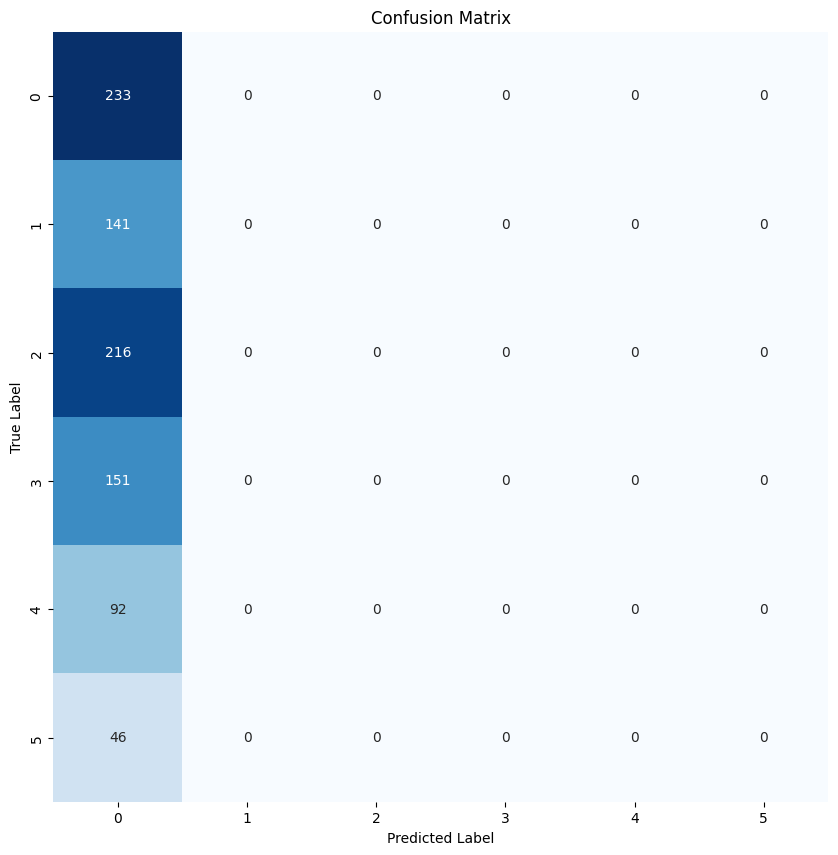

In [30]:
conf_mat = confusion_matrix(y_test_arg, y_pred_arg)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict